# Example - Instacart

This example demonstrates the feature set of FlintML using a common ML problem on Kaggle. If you would like to follow along, make sure you have finished the [quickstart](https://github.com/flintml/flintml/tree/master?tab=readme-ov-file#-quickstart) and copied the Instacart [walkthrough.ipynb](https://github.com/flintml/flintml/blob/master/docs/examples/instacart/walkthrough.ipynb) into the File Browser.

## Step 1: Download data

In [ ]:
%pip install -q kagglehub

In [ ]:
import kagglehub
import shutil
import os

# Download latest version
download_cache_path = kagglehub.dataset_download(
    "yasserh/instacart-online-grocery-basket-analysis-dataset"
)
print(download_cache_path)

## Step 2: Upload data to Flint Catalog

In [ ]:
%ls /root/.cache/kagglehub/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset/versions/1

In [ ]:
from flint import write_delta
import polars as pl
from pathlib import Path

csv_dir = Path("/root/.cache/kagglehub/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset/versions/1")

for csv_path in csv_dir.glob("*.csv"):
    table_name = csv_path.stem
    
    df = pl.read_csv(csv_path)
    write_delta(
        df,
        name=table_name,
        tags={
            "source": "external",
            "provider": "kaggle"
        }
    )
    print(f"Wrote Δ table '{table_name}' using Polars.")

### Inspect the Catalog Explorer to see the new Delta Tables

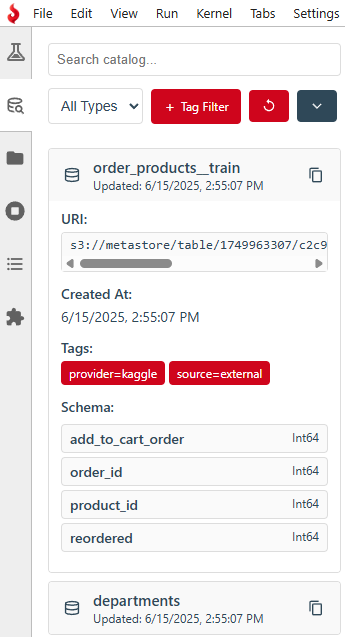

## Step 3: Explore data

In [ ]:
%pip install -q seaborn

In [ ]:
from flint import scan_delta, display
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

# Lazy load table using Polars
order_products__prior = scan_delta(
    name="order_products__prior",
    tags={
        "source": "external",
        "provider": "kaggle"
    }
)
products = scan_delta(path="products?provider=kaggle&source=external") # or copy table path from Catalog Explorer

# Lazy join
top_products = (
    order_products__prior
    .group_by("product_id")
    .agg(pl.len().alias("order_count"))
    .sort("order_count", descending=True)
    .limit(10)
    .join(products.select(["product_id", "product_name"]), on="product_id", how="left")
)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=top_products.collect(), x="order_count", y="product_name")
plt.title("Top 10 Most Frequently Ordered Products", fontsize=14)
plt.xlabel("Order Count")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()

## Step 4: Create features

In [ ]:
# Lazy load all tables
aisles = scan_delta("aisles?provider=kaggle&source=external")
departments = scan_delta("departments?provider=kaggle&source=external")
prior = scan_delta("order_products__prior?provider=kaggle&source=external")
train = scan_delta("order_products__train?provider=kaggle&source=external")
orders = scan_delta("orders?provider=kaggle&source=external")
products = scan_delta("products?provider=kaggle&source=external")

# Join prior orders with order metadata
prior_full = (
    prior
    .join(orders, on="order_id", how="inner")
)

# Aggregate user-product interaction history
user_product_features = (
    prior_full
    .group_by(["user_id", "product_id"])
    .agg([
        pl.len().alias("times_ordered"),
        pl.mean("add_to_cart_order").alias("avg_cart_position"),
        pl.max("order_number").alias("last_order_number"),
        pl.mean("reordered").alias("reorder_rate"),
    ])
)

# Add product-level info
product_features = (
    products
    .join(departments.lazy(), on="department_id", how="left")
    .join(aisles.lazy(), on="aisle_id", how="left")
)

user_product_with_meta = (
    user_product_features
    .join(product_features.select(["product_id", "product_name", "department", "aisle"]), on="product_id", how="left")
)

# Join with training set (labels)

train_orders = (
    orders
    .filter(pl.col("eval_set") == "train")
    .select(["order_id", "user_id"])
)

train_labels = (
    train_orders
    .join(train, on="order_id", how="inner")
    .select(["user_id", "product_id", "reordered"])
)

# Compute final dataset
final_features_df = (
    user_product_with_meta
    .join(train_labels, on=["user_id", "product_id"], how="left")
    .with_columns(pl.col("reordered").fill_null(0))
    .collect()
)

# Save features as Delta Table
write_delta(final_features_df, "features?env=dev")

### Display Polars DataFrame

In [ ]:
display(final_features_df.limit(1000))

### Find the features table in the Catalog Explorer

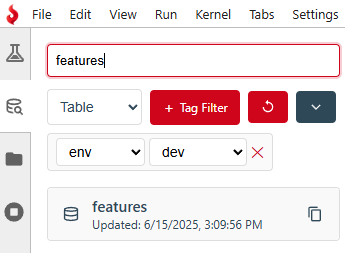

## Step 5: Train model

In [ ]:
%pip install -q xgboost scikit-learn

In [ ]:
from flint import read_delta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load full dataset into memory
df = read_delta("features?env=dev")
df = df.drop(["product_name"])

# Encode categorical columns
for col in ["department", "aisle"]:
    encoder = LabelEncoder()
    encoded = encoder.fit_transform(df[col].to_list())
    df = df.with_columns(pl.Series(name=col, values=encoded))

# Define hypothesis variables
X = df.drop(["user_id", "product_id", "reordered"])
y = df["reordered"]

# Create dataset splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Calculate class imbalance
neg, pos = (df["reordered"] == 0).sum(), (df["reordered"] == 1).sum()
ratio = neg / pos

In [ ]:
from flint import new_run
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Initialise Aim run
run = new_run(experiment="xgb-reorder-predictor")
run["hparams"] = {
    "scale_pos_weight": ratio,
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 6,
}

# Define model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=ratio,
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train model
eval_set = [("train", X_train, y_train), ("val", X_test, y_test)]
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

In [ ]:
from flint import log_artifact
import pickle

# Retroactively log metrics to Aim
results = model.evals_result()
train_losses = results["validation_0"]["logloss"]
val_losses = results["validation_1"]["logloss"]

for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    # Log untrained model as artifact
    if i == 0:
        model_bytes = pickle.dumps(model)
        log_artifact(run, model_bytes, path="untrained-model?proj=instacart", step=0)
    run.track(train_loss, name="train_loss", step=i)
    run.track(val_loss, name="val_loss", step=i)

# Final evaluation
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print(classification_report(y_test, y_pred))

run.track(acc, name="final_accuracy")

### See untrained model (artifact) in Catalog Explorer

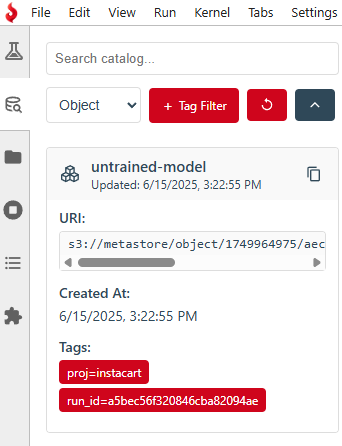

### See Run in Experiment Tracker

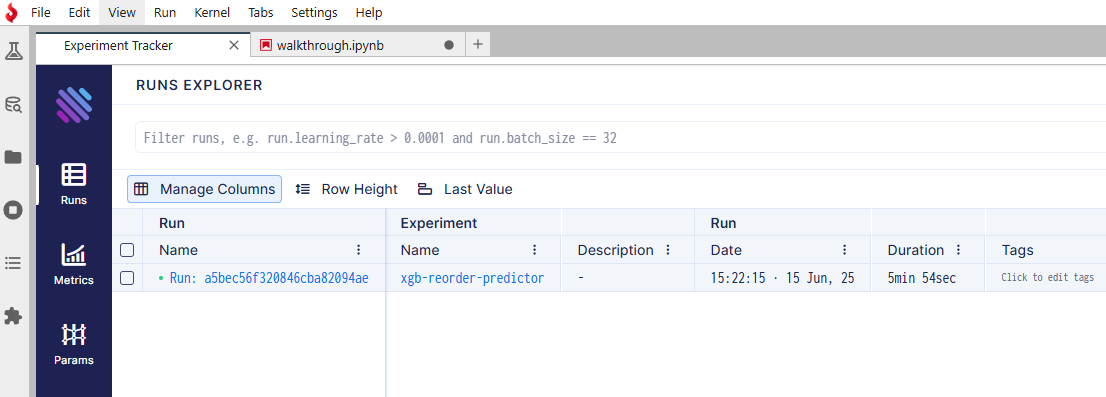

### See Run artifacts tracked as Texts in Experiment Tracker

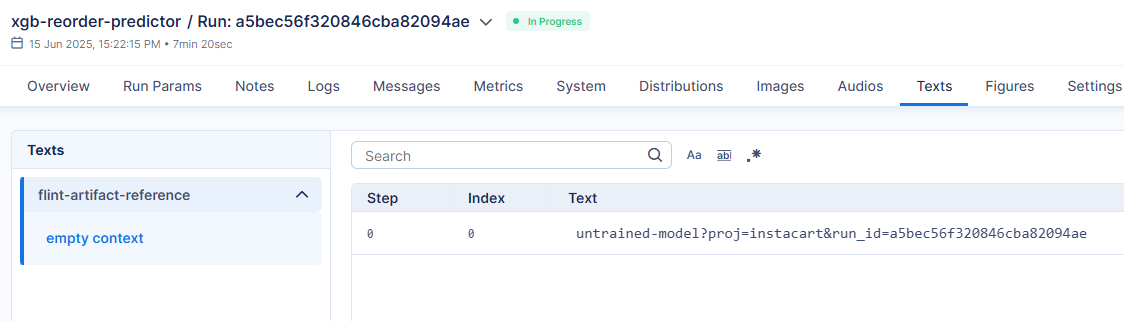